In [1]:
import warnings

warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

import numpy as np
import pandas as pd
import scanpy as sc
import os
sc.settings.verbosity = 0
#import SEACells

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Peaks data
from scipy.io import mmread

%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

sc.set_figure_params(figsize=(10,10),dpi=120)

### Load data

In [2]:
os.chdir('/lustre/scratch/kiviaho/spatac/notebooks')
rna = sc.read_h5ad('../data/seacells-rna-multiome10x-mouse.h5ad')
rna.var_names_make_unique
#rna = rna[:,~rna.var.index.duplicated()]
atac = sc.read_h5ad('../data/seacells-atac-multiome10x-mouse.h5ad')

rna.layers["counts"] = rna.raw.X.copy()
atac.layers["counts"] = atac.raw.X.copy()

atac_meta_ad = sc.read_h5ad('../data/seacell-meta-atac-multiome10x-mouse.h5ad')
rna_meta_ad  = sc.read_h5ad('../data/seacell-meta-rna-multiome10x-mouse.h5ad')
rna_meta_ad = rna_meta_ad[:,~rna_meta_ad.var.index.duplicated()]

/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
# Create integer id:s to keep track of metacells
seacell_int = np.empty(len(atac.obs.SEACell),dtype=int)
for idx,bcode in enumerate(np.unique(atac.obs.SEACell)):
    seacell_int[np.where(atac.obs.SEACell == bcode )[0]] = idx
atac.obs['SEACell_id'] = seacell_int
if all(atac.obs_names == rna.obs_names):
    rna.obs['ATAC_SEACell'] = atac.obs.SEACell
    rna.obs['ATAC_SEACell_id'] = seacell_int

In [4]:
## simulation settings
seed = 35342 # changed from 253286

In [5]:
# Sample cells attributatble to 5 metacells
np.random.seed(seed)
metacells = np.unique(atac.obs.SEACell)
metacells_to_keep = np.random.choice(metacells,5)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


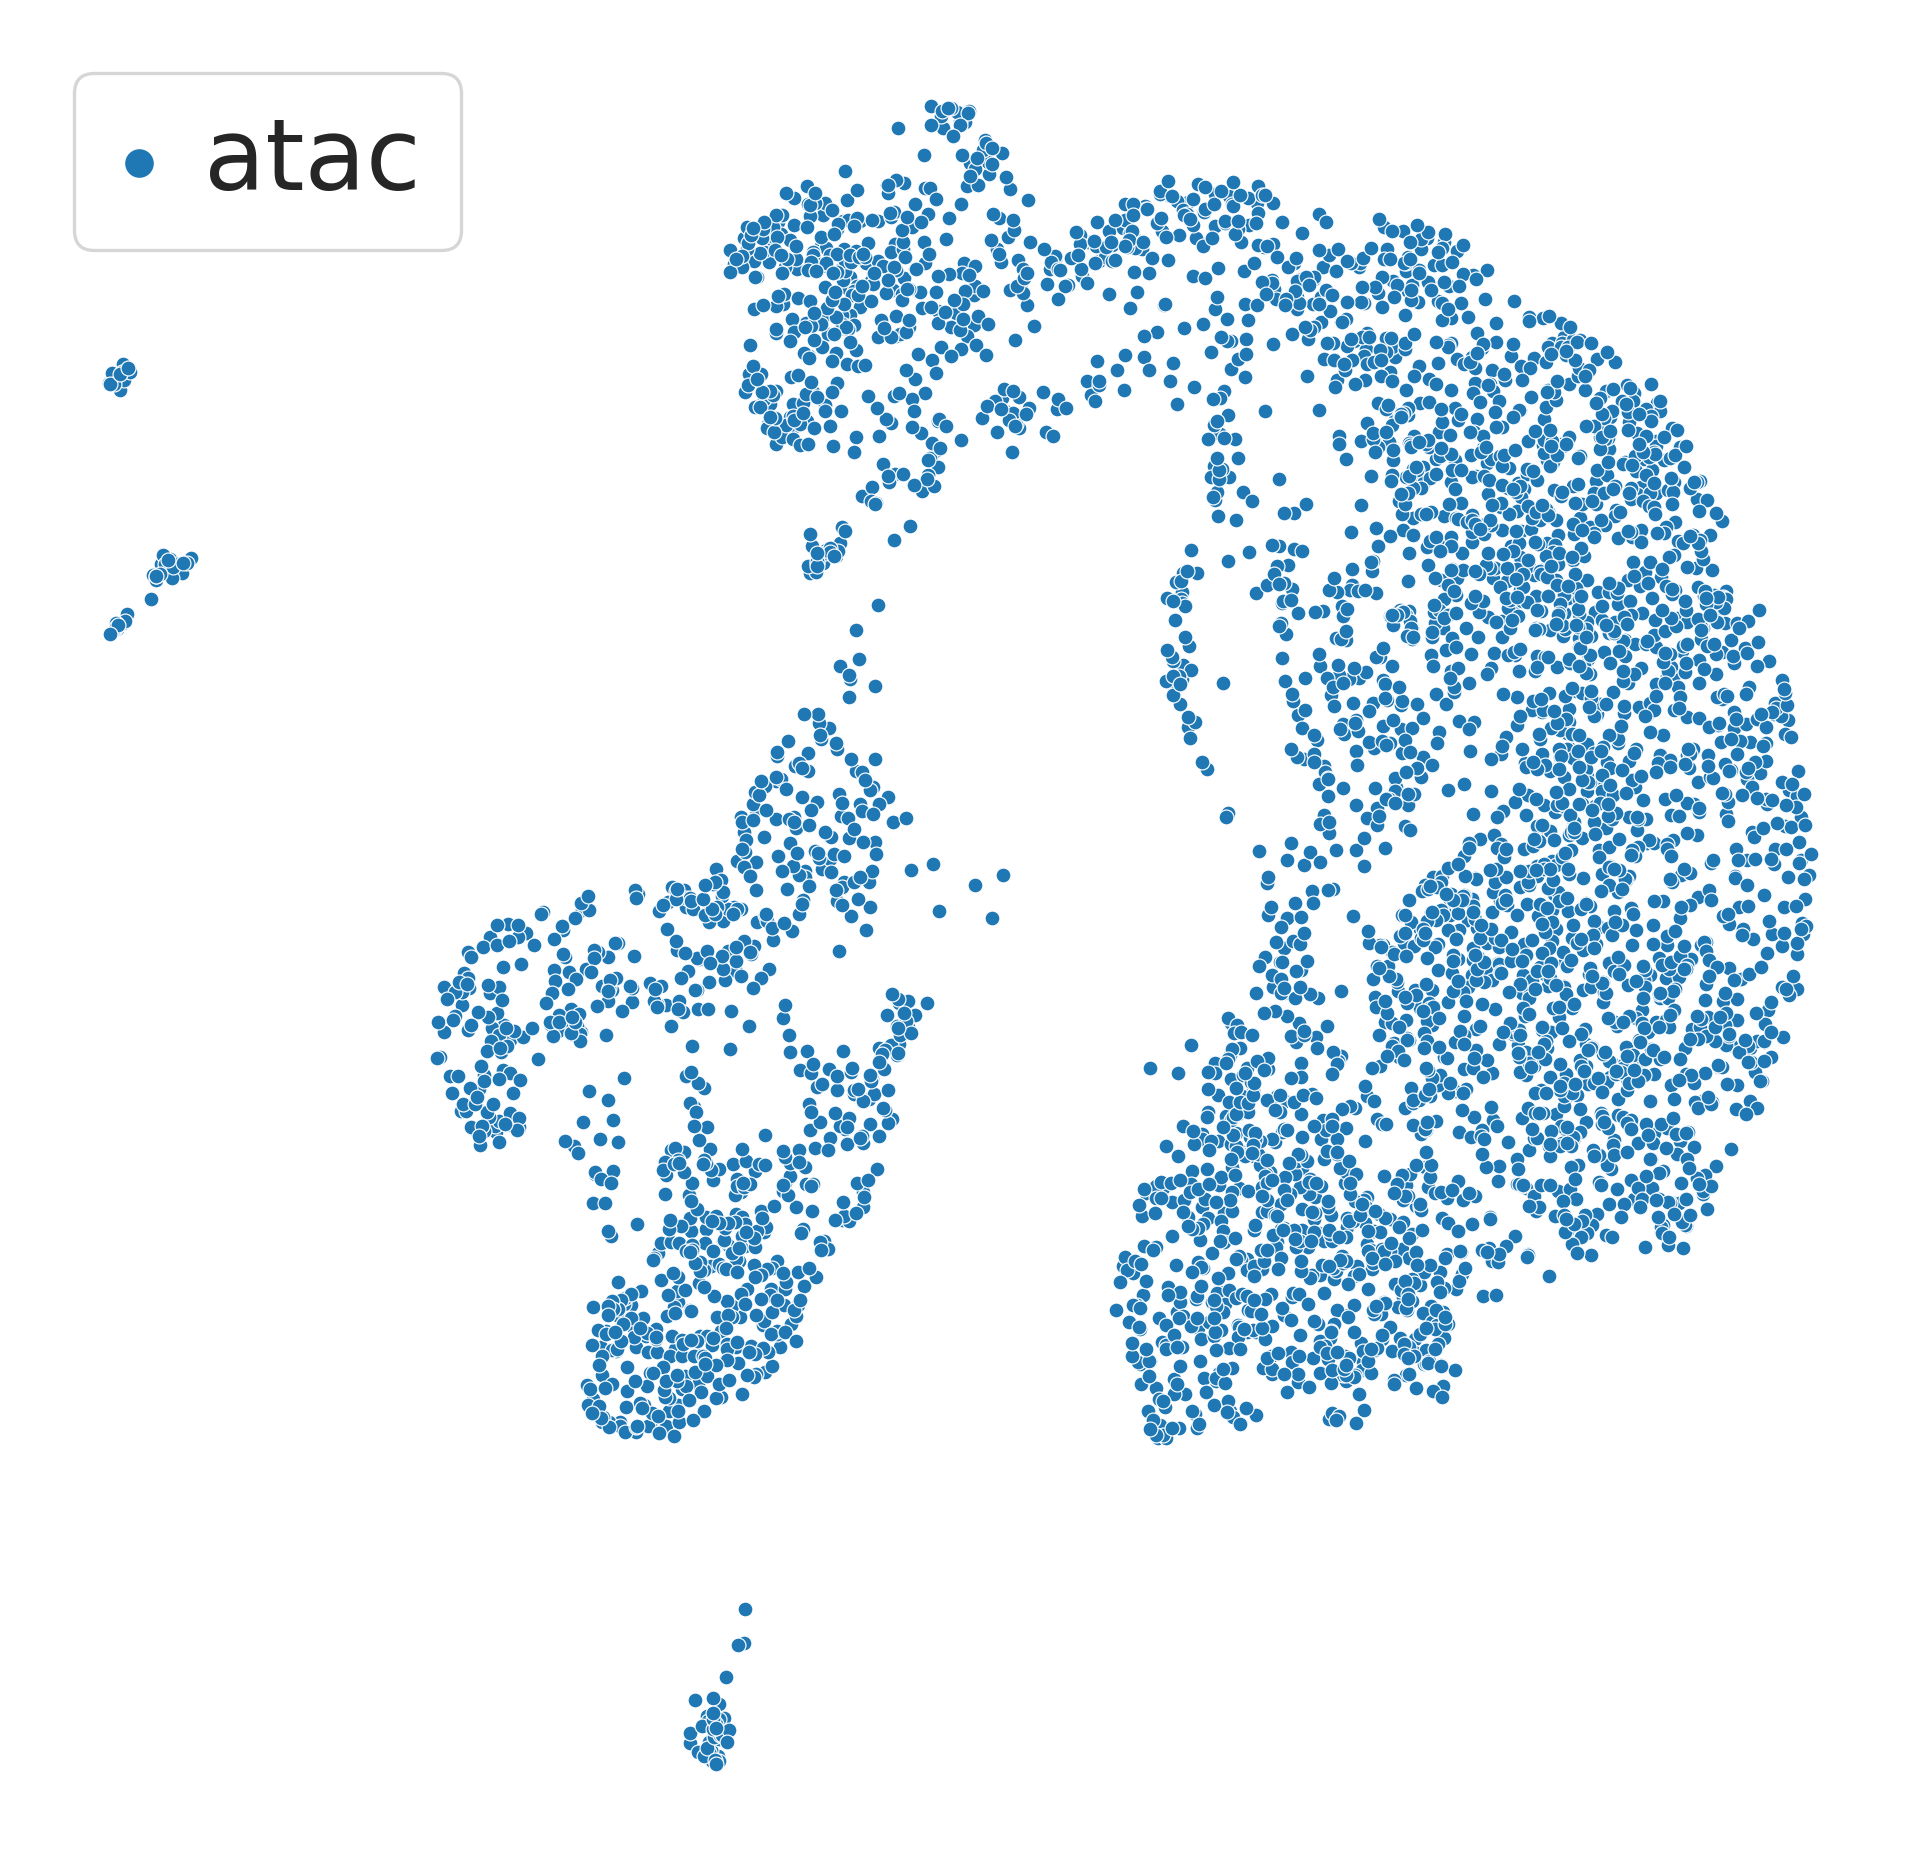

In [6]:
from matplotlib import cm
umap = pd.DataFrame(atac.obsm['X_umap']).set_index(atac.obs_names).join(atac.obs['SEACell_id'])
umap = umap.sort_values(['SEACell_id'])
umap['SEACell_id'] = umap['SEACell_id'].astype(str)
sns.scatterplot(x=0, y=1,
                    data=umap,
                    s=20,
                    c = cm.get_cmap('tab10').colors[0],
                    legend='brief')
plt.legend(['atac'],fontsize=30,markerscale=2)
ax = plt.gca()
ax.set_axis_off()


In [ ]:
umap = pd.DataFrame(rna.obsm['X_umap']).set_index(rna.obs_names).join(rna.obs['ATAC_SEACell_id'])
umap = umap.sort_values(['ATAC_SEACell_id'])
umap['ATAC_SEACell_id'] = umap['ATAC_SEACell_id'].astype(str)
sns.scatterplot(x=0, y=1,
                    data=umap,
                    s=20,
                    c = cm.get_cmap('tab10').colors[1],
                    legend='brief')
plt.legend(['rna'],fontsize=30,markerscale=2)
ax = plt.gca()
ax.set_axis_off()

<AxesSubplot:xlabel='0', ylabel='1'>

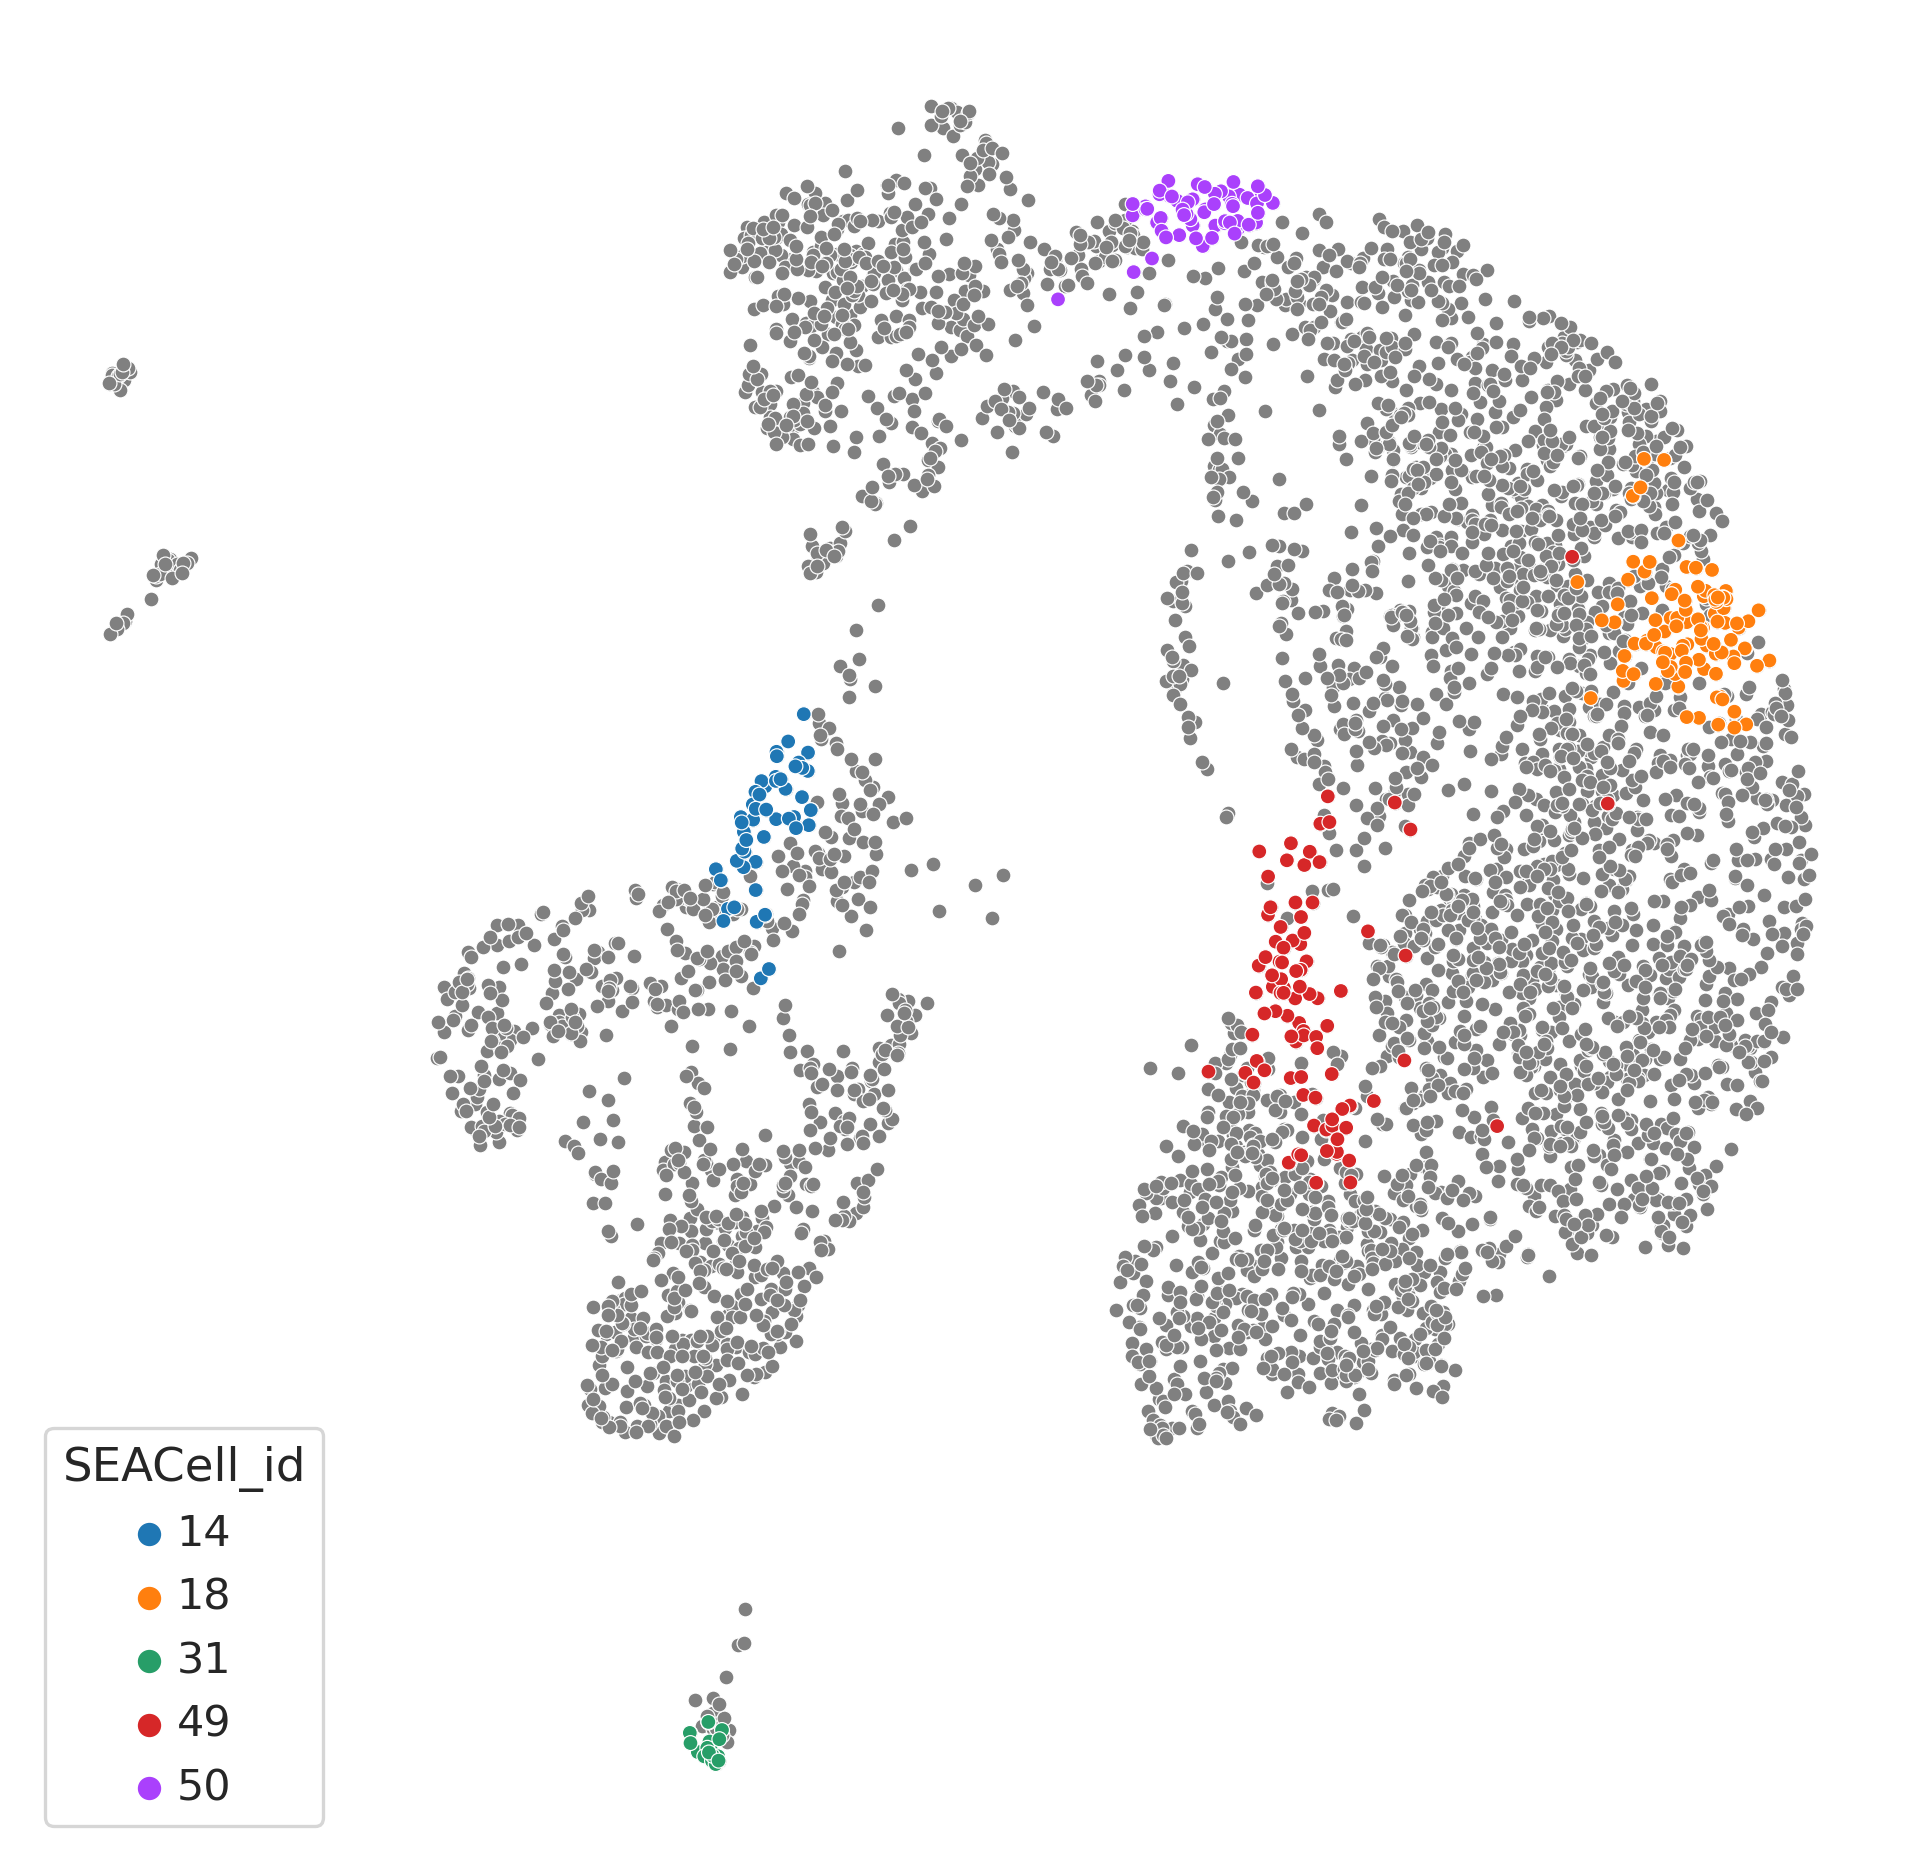

In [7]:
sns.scatterplot(x = atac.obsm['X_umap'][:,0],y=atac.obsm['X_umap'][:,1],color='gray',s=20)
ax = plt.gca()
ax.set_axis_off()

subs_atac = atac[atac.obs.SEACell.isin(metacells_to_keep)]

umap = pd.DataFrame(subs_atac.obsm['X_umap']).set_index(subs_atac.obs_names).join(subs_atac.obs['SEACell_id'])
umap = umap.sort_values(['SEACell_id'])
umap['SEACell_id'] = umap['SEACell_id'].astype(str)
sns.scatterplot(x=0, y=1,
                    hue='SEACell_id',
                    data=umap,
                    s=20,
                    cmap='Set2',
                    legend='brief')



In [ ]:
sns.scatterplot(x = rna.obsm['X_umap'][:,0],y=rna.obsm['X_umap'][:,1],color='gray',s=20)
ax = plt.gca()
ax.set_axis_off()


In [8]:
subs_rna = rna[rna.obs.ATAC_SEACell.isin(metacells_to_keep)]
umap = pd.DataFrame(subs_rna.obsm['X_umap']).set_index(subs_rna.obs_names).join(subs_rna.obs['ATAC_SEACell_id'])
umap = umap.sort_values(['ATAC_SEACell_id'])
umap['ATAC_SEACell_id'] = umap['ATAC_SEACell_id'].astype(str)


In [ ]:
atac

In [ ]:
rna

In [ ]:
# # Save single-cell-resolution-data-for-glue
# atac.write('../integrations/multiome_5k/single_cell_all/atac.h5ad')
# rna.write('../integrations/multiome_5k/single_cell_all/rna.h5ad')

## Synthetic spatial spot sampling

In [9]:
n_locations = [60, 60] # 50*50 grid
n_experiments = 1 # Changed from 10

# sparsity and tissue zones
n_tissue_zones = 3 # Changed from 12
n_uniform = 0 # Changed from 8

# low and high density cell types
p_high_density = 1 # Changed from 0.2, 
mu_low_density = 1.0
mu_high_density = 2.8

In [10]:
## simulation settings
np.random.seed(seed)

## generate per cell type simulation attributes
n_cell_types = subs_rna.obs['ATAC_SEACell_id'].value_counts().shape[0]
n_sparse = n_cell_types - n_uniform
n_zones_per_cell_type = np.random.binomial(n_tissue_zones, 0.02, size=n_sparse)+1

experiment_id = np.repeat(np.arange(n_experiments), np.prod(n_locations))
cell_types = np.array(subs_rna.obs['ATAC_SEACell_id'].unique())
uniform_cell_types = np.random.choice(cell_types, n_uniform, replace=False)
sparse_cell_types = cell_types[~np.isin(cell_types, uniform_cell_types)]

# generate matrix of which cell types are in which zones
cell_types2zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'tissue_zone_{i}' for i in range(n_tissue_zones)] \
                                + [f'uniform_{i}' for i in range(n_uniform)])
for i, n in enumerate(n_zones_per_cell_type):
    pos = np.random.randint(n_tissue_zones, size=n)
    cell_types2zones.iloc[i,pos] = 1
    
# and which uniform cell types belong to which uniform pattern
for i in range(n_uniform):
    cell_types2zones.iloc[n_sparse+i, n_tissue_zones+i] = 1
    
cell_types2zones.sum(), cell_types2zones.sum(1)

(tissue_zone_0    1
 tissue_zone_1    2
 tissue_zone_2    2
 dtype: int64,
 31    1
 18    1
 49    1
 50    1
 14    1
 dtype: int64)

In [11]:
np.random.seed(seed)
# Assign cell types to either high or low density, balanced by uniform / tissue zone
high_density_cell_types = list(np.random.choice(uniform_cell_types, 
                                                int(np.round(n_uniform * p_high_density)), 
                                                replace=False))
for z, n in cell_types2zones.sum().items():
    
    ct = list(np.random.choice(cell_types2zones.index[cell_types2zones[z] > 0], 
                                                int(np.round(n * p_high_density)), 
                                                replace=False))
    print(ct)
    high_density_cell_types = high_density_cell_types + ct
    
low_density_cell_types = cell_types[~np.isin(cell_types, high_density_cell_types)]
    
# what proportion of cells are uniform?
len(high_density_cell_types) / len(cell_types)

[14]
[50, 18]
[31, 49]


1.0

In [12]:
cell_types2zones

,tissue_zone_0,tissue_zone_1,tissue_zone_2
31,0,0,1
18,0,1,0
49,0,0,1
50,0,1,0
14,1,0,0


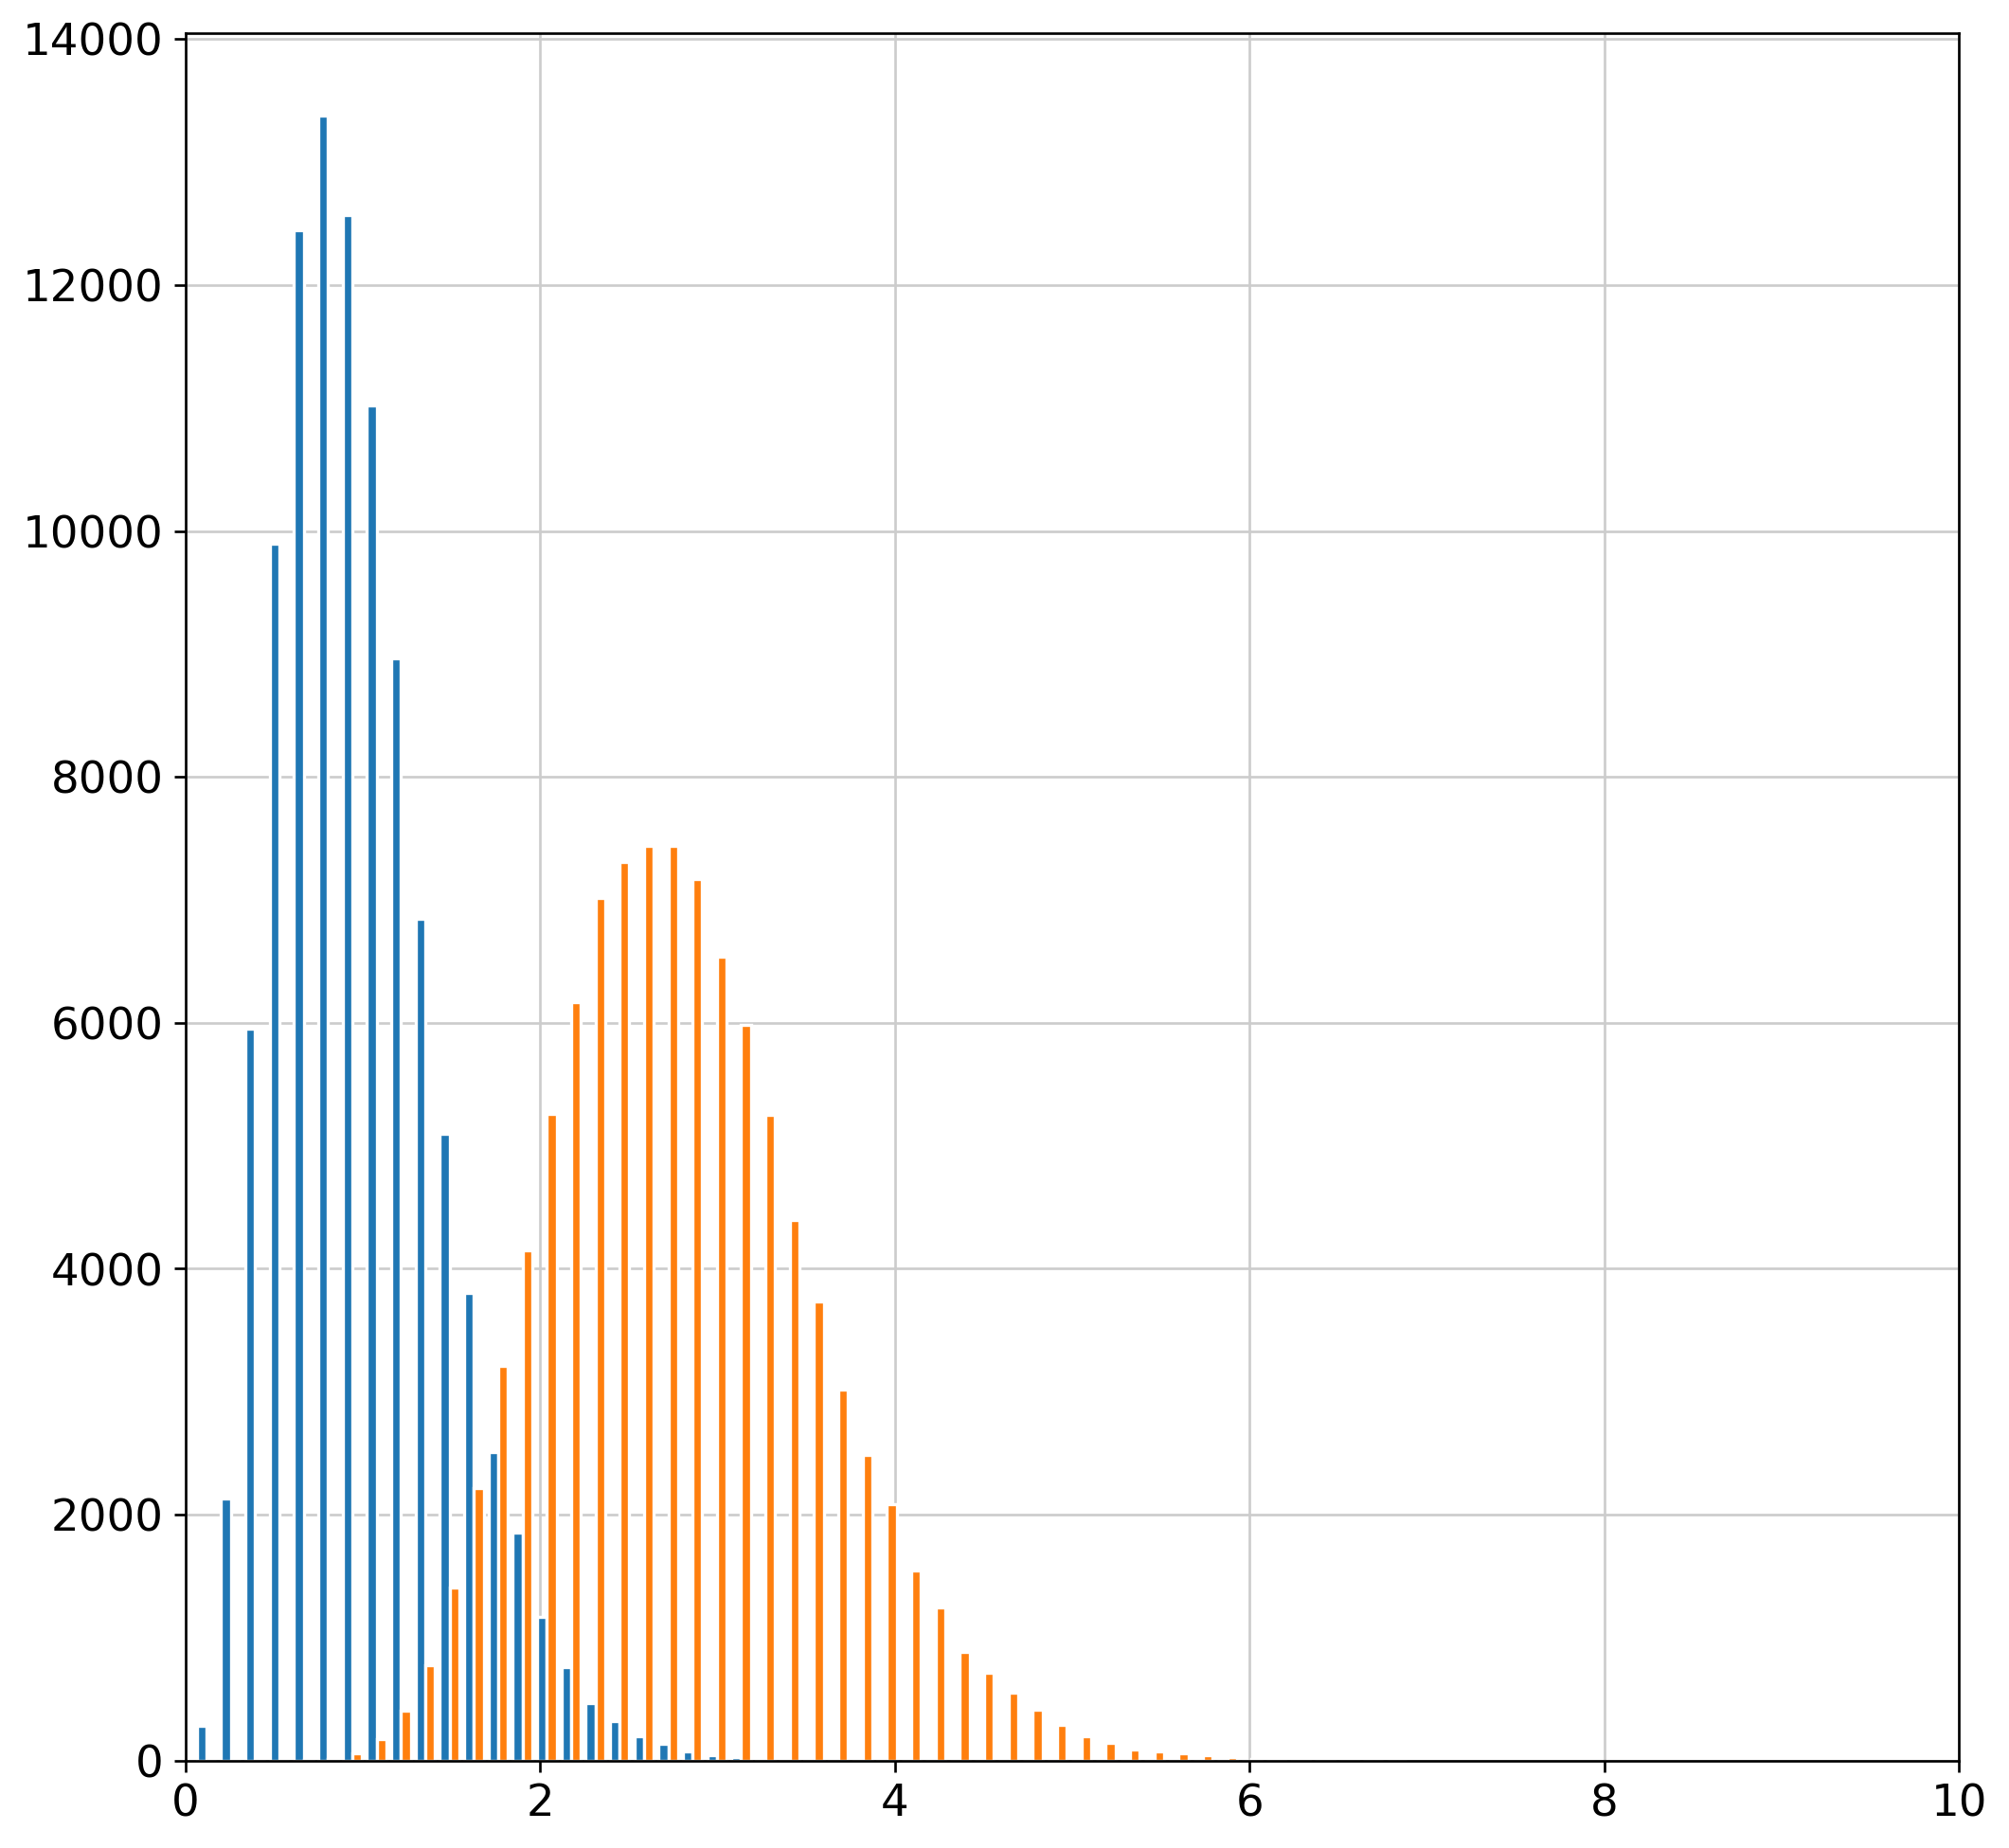

In [13]:
np.random.seed(seed)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5
plt.hist([np.random.gamma(mu_low_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5)),
          np.random.gamma(mu_high_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5))], bins=50);
plt.xlim(0, 10);

cell_types2zones.loc[low_density_cell_types] = cell_types2zones.loc[low_density_cell_types] \
 * np.random.gamma(mu_low_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(low_density_cell_types), 1))

cell_types2zones.loc[high_density_cell_types] = cell_types2zones.loc[high_density_cell_types] \
 * np.random.gamma(mu_high_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(high_density_cell_types), 1))

In [ ]:
cell_types2zones

In [14]:
def cartesian(*arrays):
    """Makes the Cartesian product of arrays.

    Parameters
    ----------
    arrays: N-D array-like
            N-D arrays where earlier arrays loop more slowly than later ones
    """
    N = len(arrays)
    arrays_np = [np.asarray(x) for x in arrays]
    arrays_2d = [x[:, None] if np.asarray(x).ndim == 1 else x for x in arrays_np]
    arrays_integer = [np.arange(len(x)) for x in arrays_2d]
    product_integers = np.stack(np.meshgrid(*arrays_integer, indexing="ij"), -1).reshape(-1, N)
    return np.concatenate(
        [array[product_integers[:, i]] for i, array in enumerate(arrays_2d)], axis=-1
    )

def kernel(X1, X2, l=1.0, eta=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return eta**2 * np.exp(-0.5 / l**2 * sqdist)
    
def generate_grid(
              n=[50, 50] #spatial dimensions 
):
    n1, n2 = n 
    x1 = np.linspace(0, 100, n1)[:,None] #saptial dimensions 
    x2 = np.linspace(0, 100, n2)[:,None] #saptial dimensions 

    # make cartesian grid out of each dimension x1 and x2
    return cartesian(x1[:,None], x2[:,None]), x1, x2

def random_GP(X, x1=1, x2=1, #coordinates
              n_variables = 5, #zones
              eta_true = 5, #variance, defines overlapping
              l1_true=[8, 10, 15], #bw parameter
              l2_true=[8, 10, 15]
             ):

    #cov1, cov2 = kernel(x1, x1, l=l1_true), kernel(x2, x2, l=l2_true)
    K = [np.kron(kernel(x1, x1, l=l1_true[i], eta=eta_true), 
                 kernel(x2, x2, l=l2_true[i], eta=eta_true)) 
         for i in range(n_variables)]

    gaus_true = np.stack([np.random.multivariate_normal(np.zeros(X.shape[0]), 
                                                        2*K[i]) 
                          for i in range(n_variables)]).T #samples from GP
    N_true = (np.exp(gaus_true).T / np.exp(gaus_true).sum(axis=1)).T #softmax transform, eq 48
    return N_true


def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for ct in range(n_cell_types):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax
                  )
        plt.colorbar()
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.title('total')

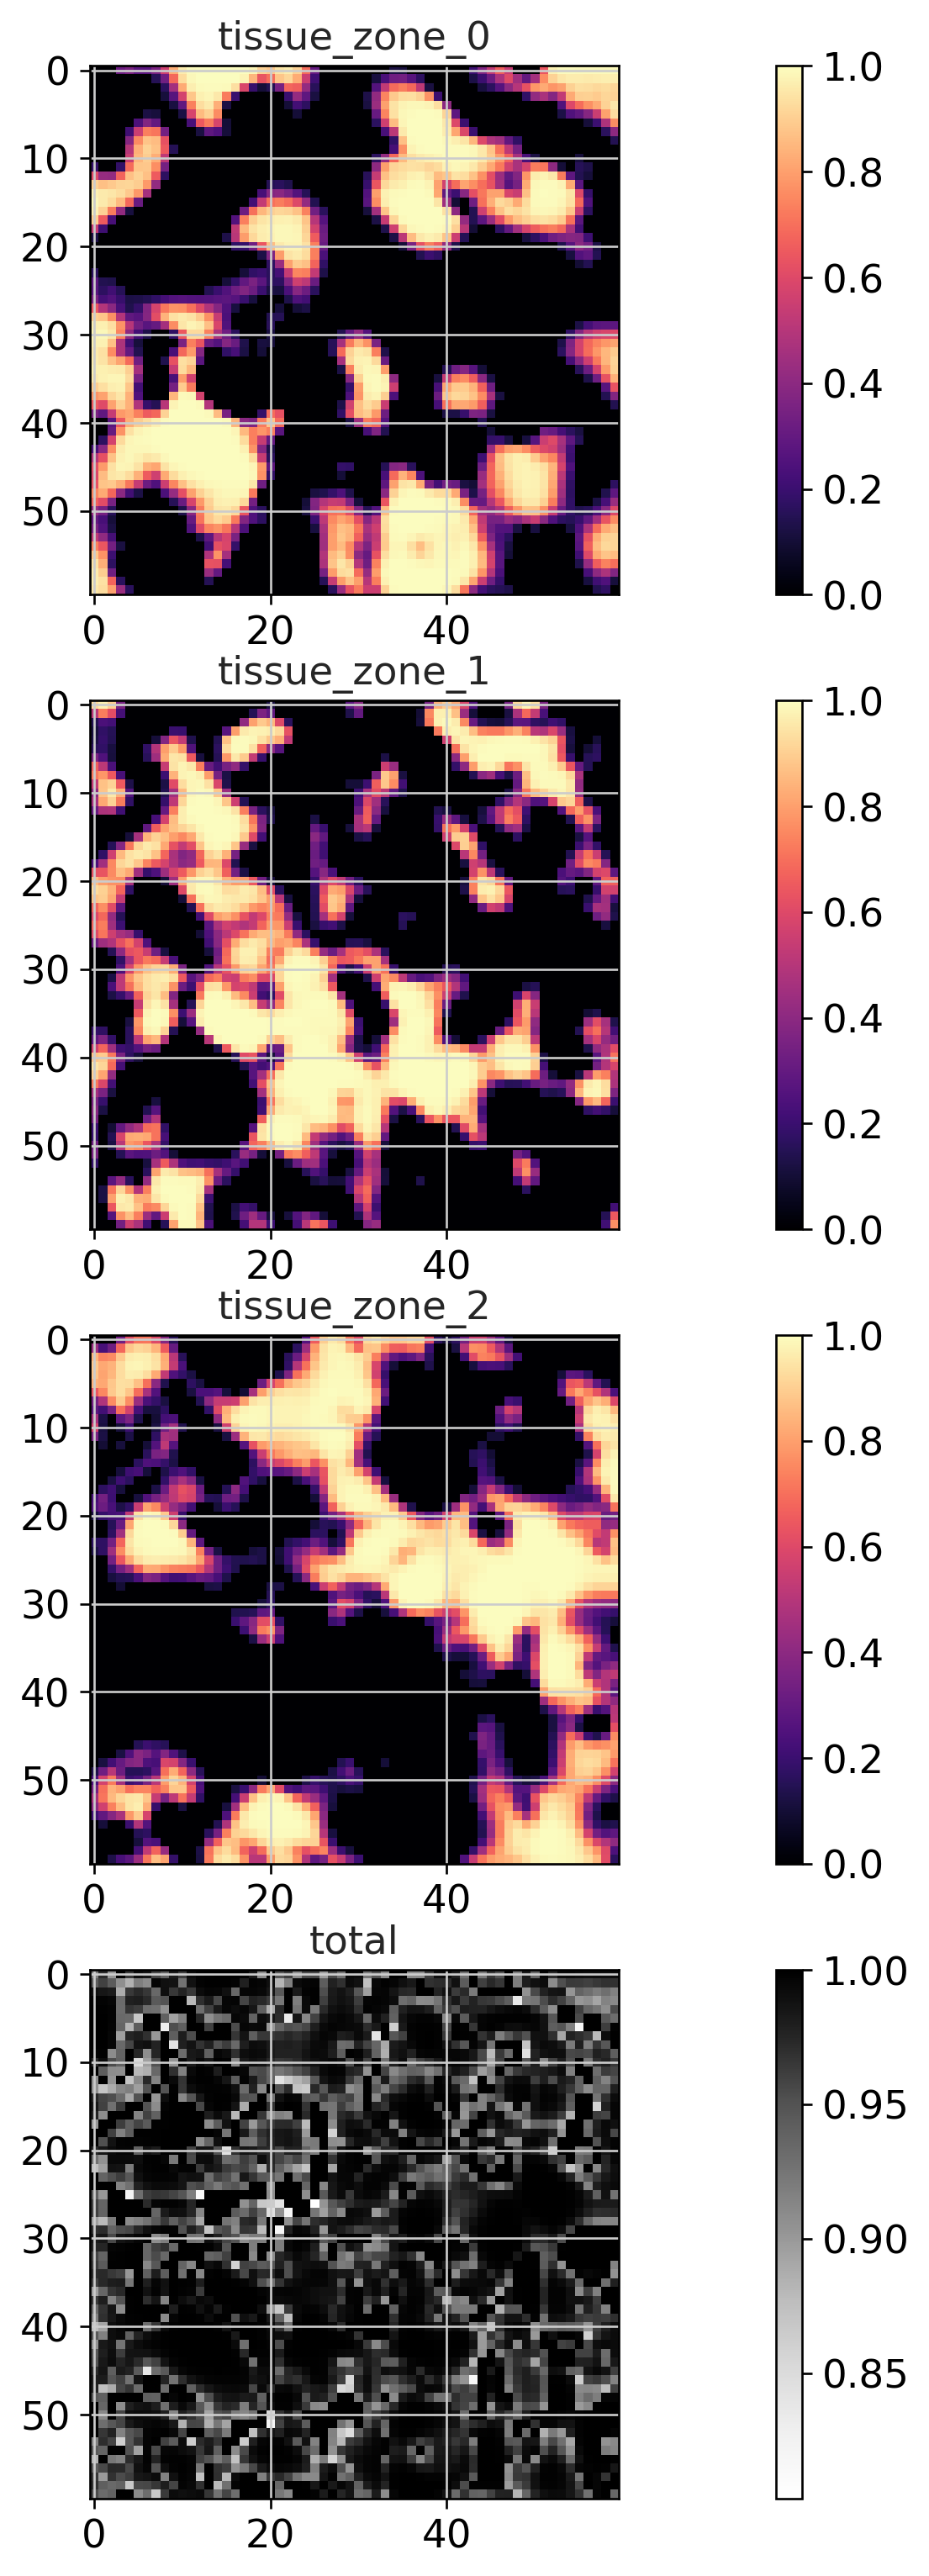

In [15]:
np.random.seed(seed)
# Sample bw parameter
mean_var_ratio = 1.2
mean = 8
tissue_zones_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                       size=(n_tissue_zones))
uniform_cell_types_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                             size=(len(uniform_cell_types)))
def sample_GP(locations, x1, x2):
    # Sample abundances with GP
    sparse_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=n_tissue_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    sparse_abundances = sparse_abundances / sparse_abundances.max(0)
    sparse_abundances[sparse_abundances < 0.1] = 0

    if len(uniform_cell_types!=0):
        uniform_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=len(uniform_cell_types), 
                                                          eta_true=0.5,
                                                        l1_true=uniform_cell_types_l1_true,
                                                        l2_true=uniform_cell_types_l1_true)
        uniform_abundances = uniform_abundances / uniform_abundances.max(0) # eq 49
        uniform_abundances[uniform_abundances < 0.1] = 0

        abundances = np.concatenate([sparse_abundances, uniform_abundances], axis=1)
    else:
        abundances = sparse_abundances
    
    return pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_types2zones.columns
                                )

locations_1, x1, x2 = generate_grid(n=n_locations)
locations = np.concatenate([locations_1 for _ in range(n_experiments)], axis=0)

abundances_df = pd.DataFrame()

for e in range(n_experiments):
    
    abundances_df_1 = sample_GP(locations_1, x1, x2)
    abundances_df_1.index = [f'exper{e}_{l}' for l in abundances_df_1.index]
    abundances_df = pd.concat((abundances_df, abundances_df_1), axis=0)
    
    plt.figure(figsize=(3*5+5,3*5+5))
    plot_spatial(abundances_df_1.values, n=n_locations, nrows=5, names=abundances_df.columns)
    plt.show()

In [16]:
# HERE w_sf = sum_r(z_sr,x_rf)*q_sf
np.random.seed(seed)
cell_abundances = np.dot(abundances_df, cell_types2zones.T)
cell_abundances = cell_abundances * np.random.lognormal(0, 0.35, size=cell_abundances.shape)
cell_abundances_df = pd.DataFrame(cell_abundances, 
                             index=abundances_df.index,
                             columns=cell_types2zones.index
                            )
# Plots just the first experiment
# plt.figure(figsize=(3*5+5, 3*10+5))
# plot_spatial(cell_abundances_df.values[experiment_id==0,:], 
#              n=n_locations, nrows=8, 
#              names=cell_abundances_df.columns, vmax=None)
# plt.show()


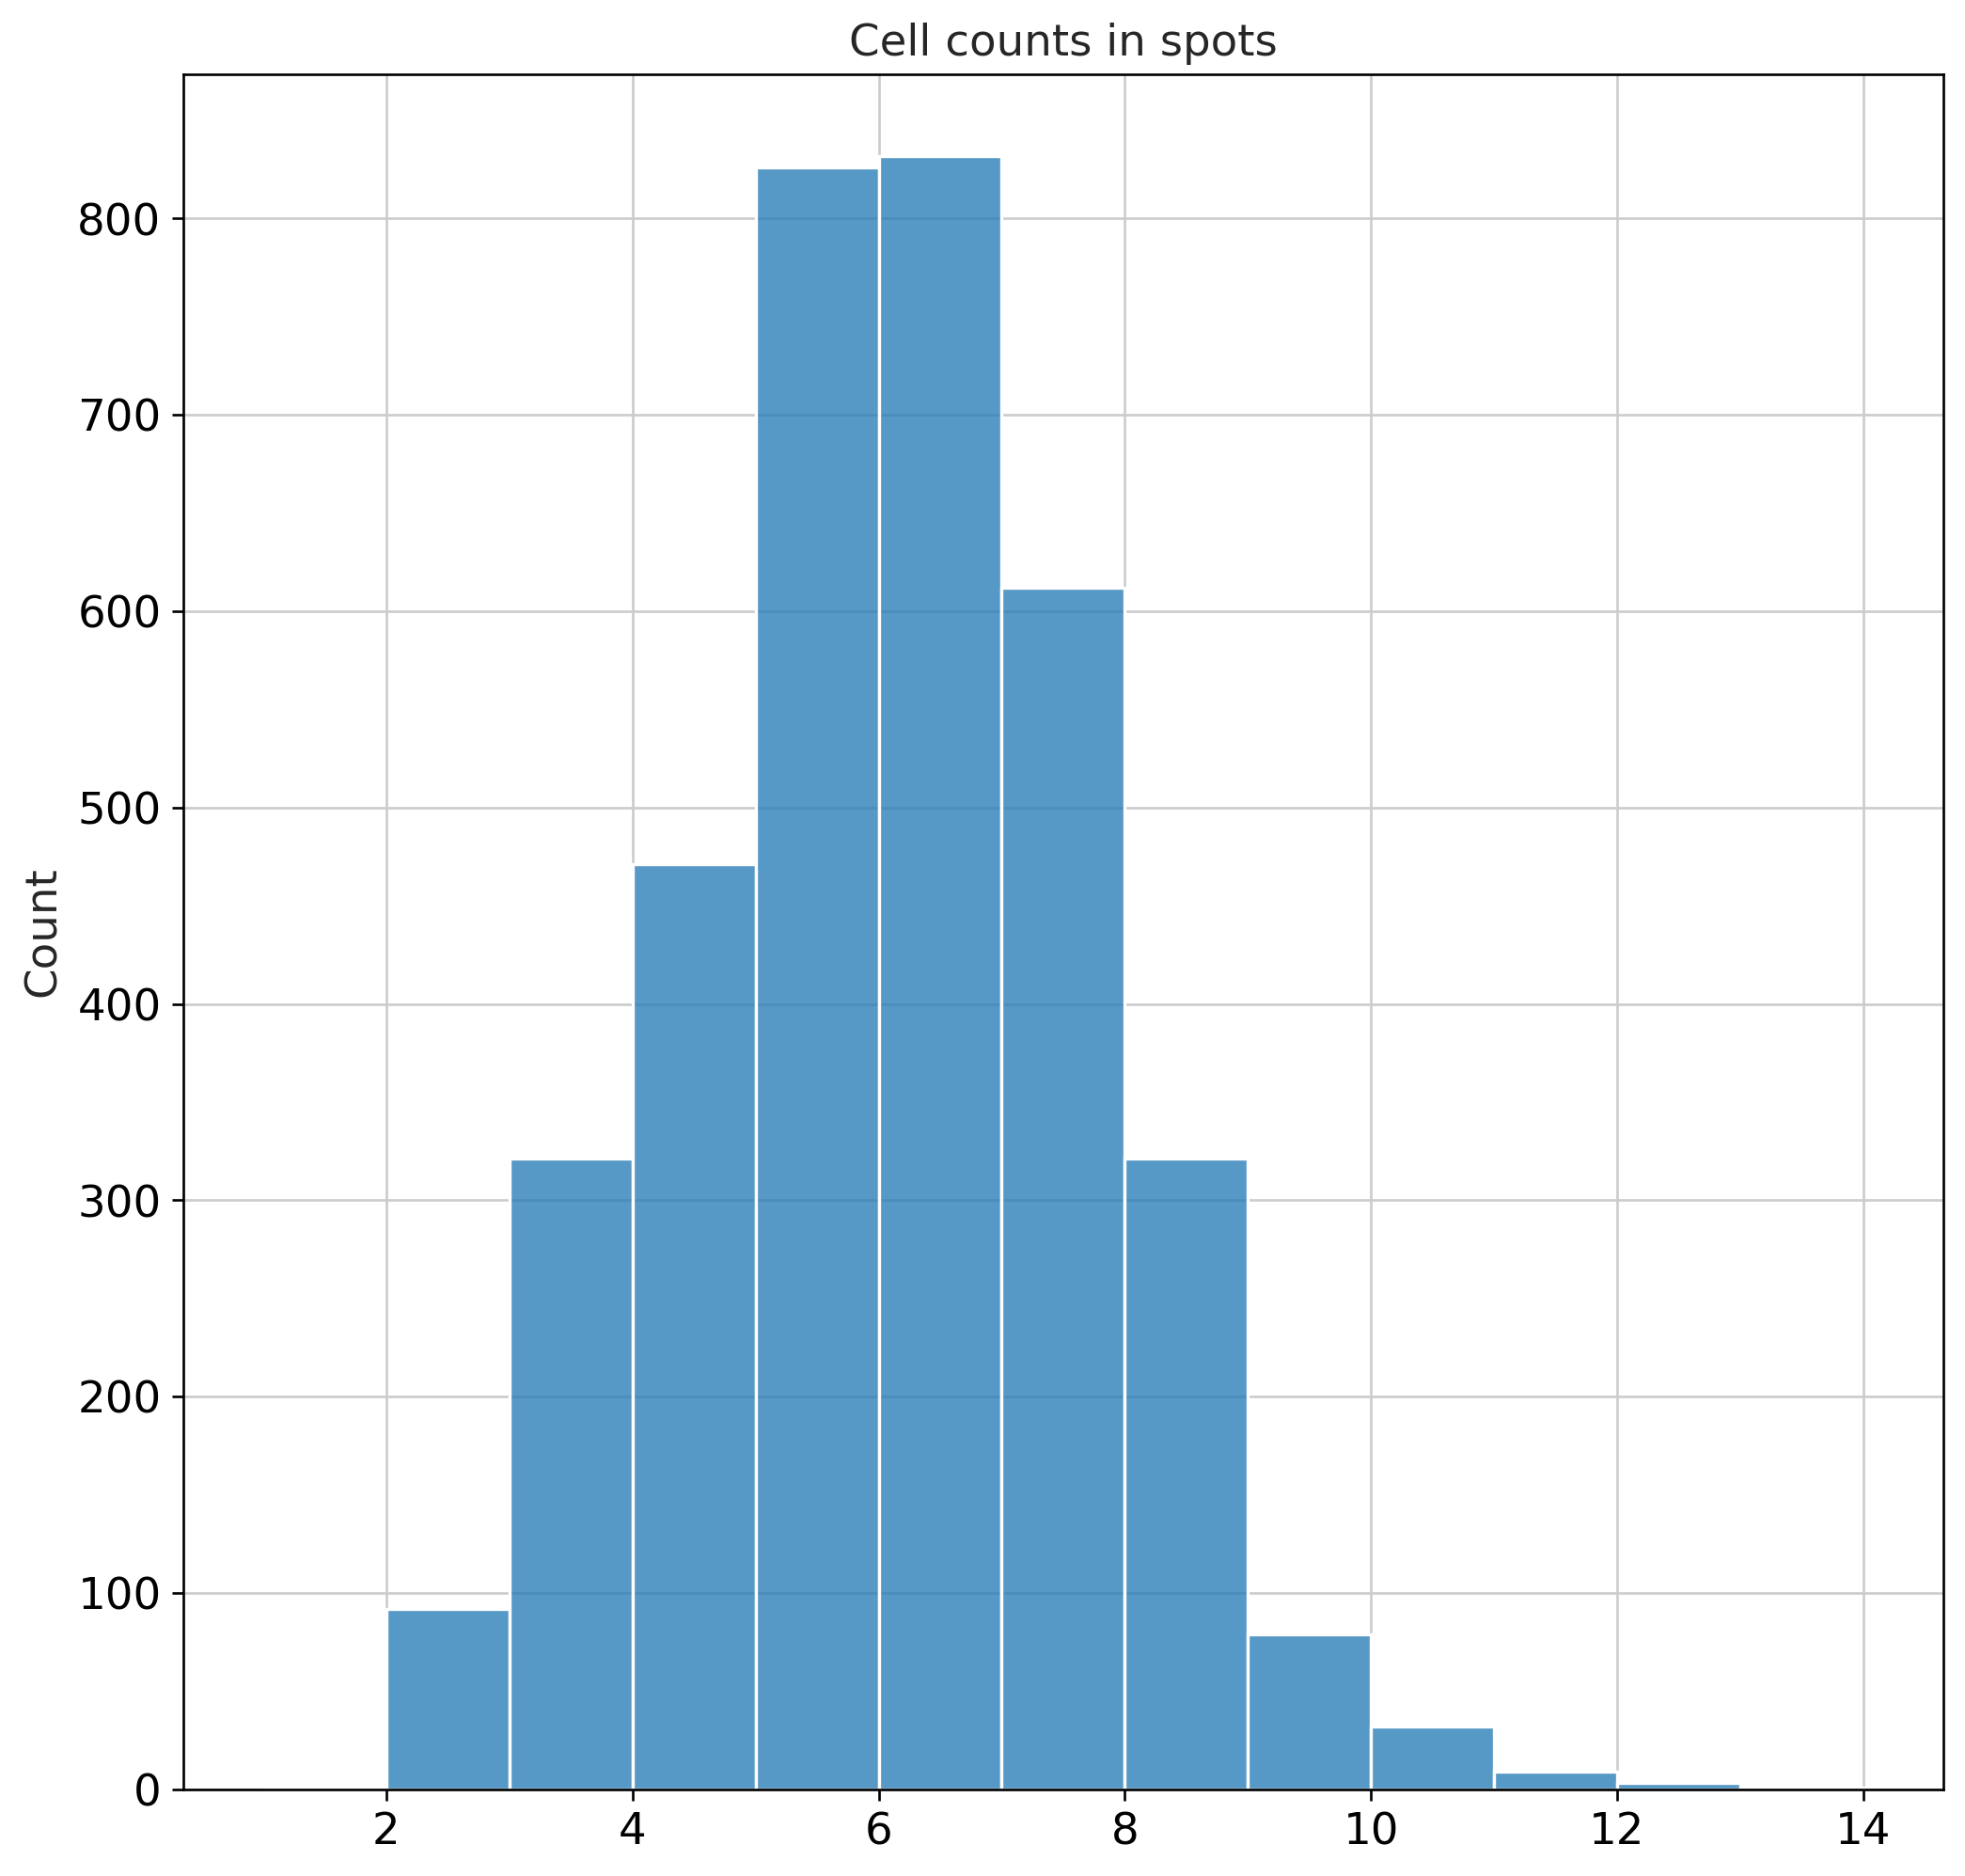

31    3175.0
18    3832.0
49    5139.0
50    3516.0
14    4524.0
dtype: float64

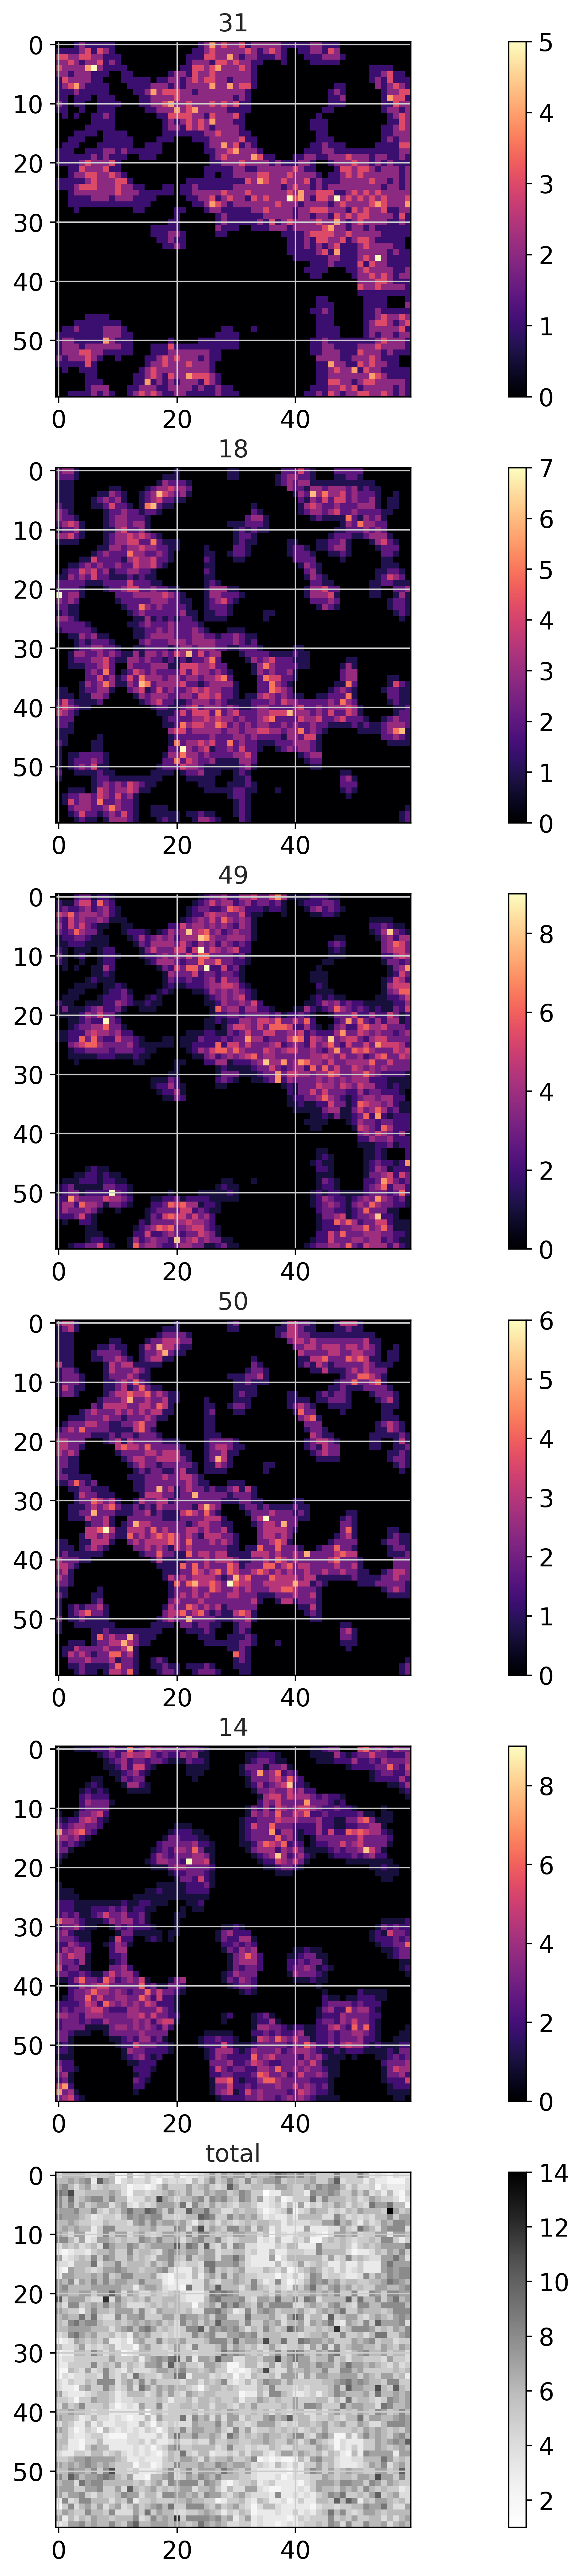

In [17]:
cell_count_df = np.ceil(cell_abundances_df)
sns.histplot(cell_count_df.sum(1),binwidth=1);
plt.title('Cell counts in spots')
plt.show();

plt.figure(figsize=(3*5+5, 3*10+5),dpi=200)
plot_spatial(cell_count_df.values[experiment_id==0,:], 
             n=n_locations, nrows=8, 
             names=cell_count_df.columns, vmax=None)

cell_count_df.sum(0)

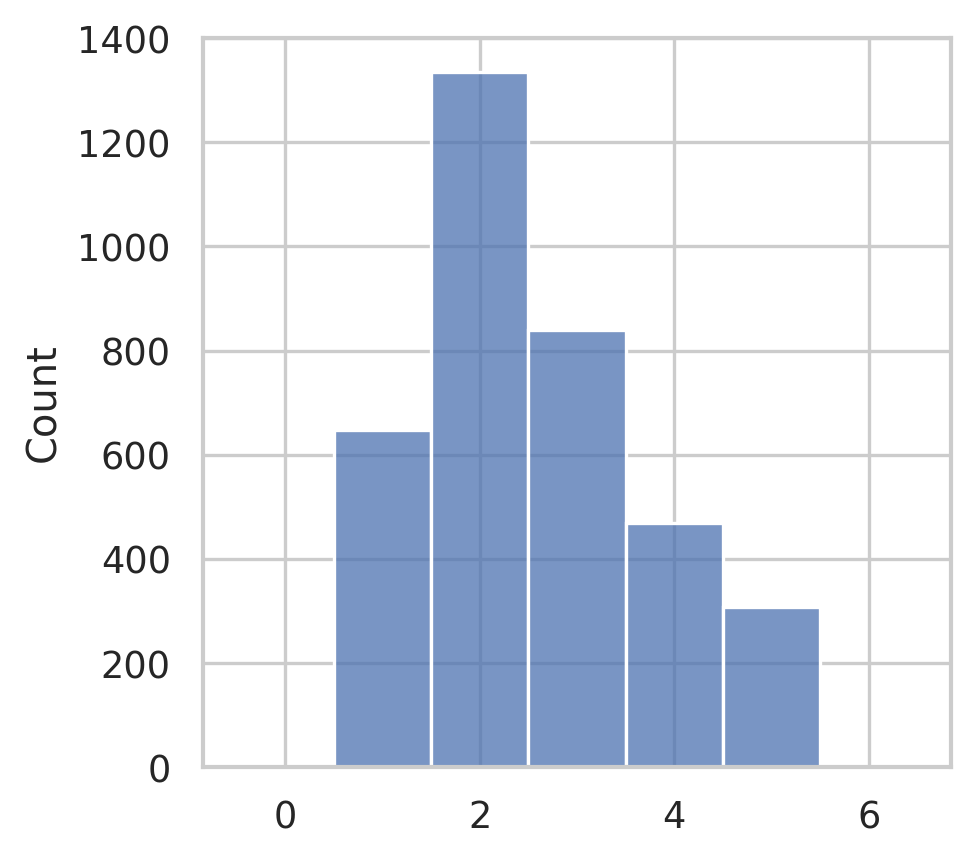

In [18]:
plt.figure(figsize=(4,4),dpi=120)
sns.set_theme(style='whitegrid')
sns.histplot(cell_count_df.astype(bool).astype(int).sum(axis=1),discrete=True,binrange=(0,6))
plt.savefig('../plots/synthetic-spatial-celltype-count-histplot.png',dpi=600)
#plt.title('The number of diferent cell types in spatial spots')

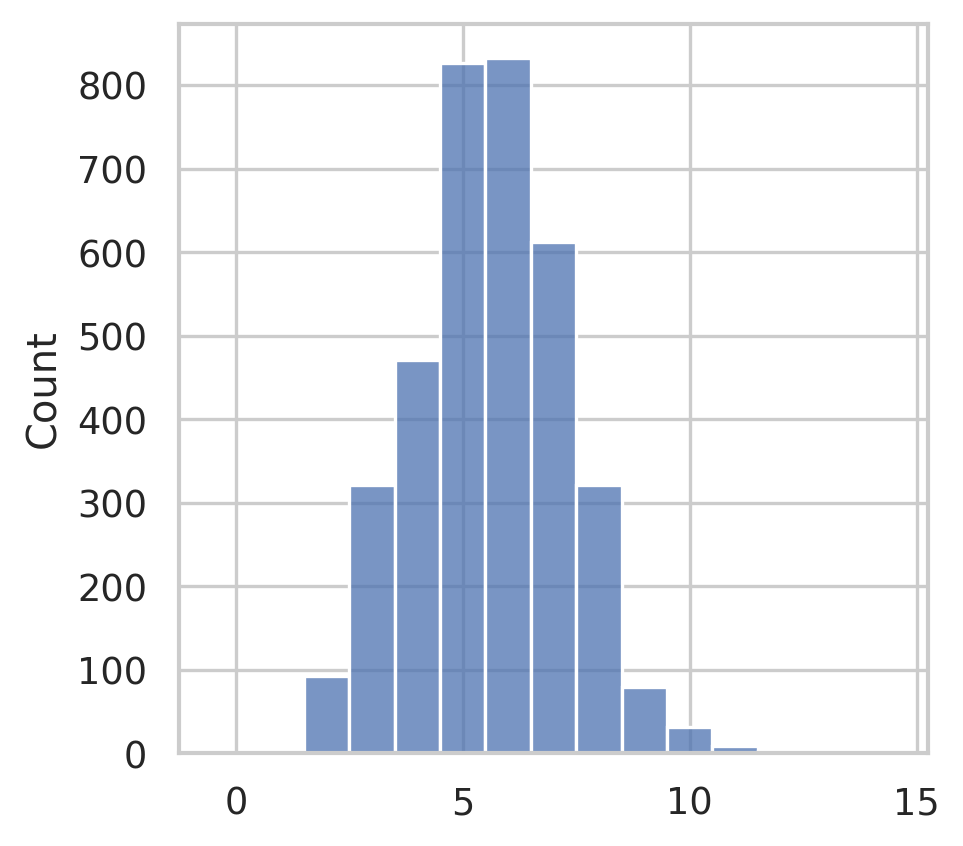

In [19]:
plt.figure(figsize=(4,4),dpi=120)
sns.set_theme(style='whitegrid')
sns.histplot(cell_count_df.sum(axis=1),discrete=True,binrange=(0,14))
plt.savefig('../plots/synthetic-spatial-cell-count-histplot.png',dpi=600)
#plt.title('The number of diferent cell types in spatial spots')


In [20]:
def construct_spotwise_expression(expression_df,cells_df,np_seed=35342):
    '''
    expression_df: anndata object with RNA transcript or ATAC peak counts in layer X should
                   contain a column named class_id with identifiers matching those in cells_df

    cells_df: a pandas dataframe containing synthetic spatial spots as rows and cell-types
              as columns. Entries represent integer cell counts of each type in each spot.
              Columns should be named appropriately.
    '''
    
    np.random.seed(np_seed)
    
    simulated_data = np.empty((len(cells_df),len(expression_df.var)),dtype=np.int16)
    celltypes = cells_df.columns.astype(int)
    
    for row_idx, row in cells_df.reset_index(drop=True).iterrows():
        select_indices = np.empty((0))

        for col_idx,cell_count in enumerate(row): # Iterates over columns in each row
            celltype = celltypes[col_idx]
            celltype_indices = np.where(expression_df.obs['class_id']==celltype)[0] 

            # Random select from matching indices according to number of cells present
            select_indices = np.append(select_indices,np.random.choice(celltype_indices,int(cell_count))).astype(int)

        # Subsets ATAC by selected index and produces a sum of those cells' peaks, appends to 
        # correct synthetic spot
        simulated_data[row_idx,:] = np.sum(expression_df.X[select_indices,:].toarray(),axis=0,dtype=np.int16)
    return simulated_data


#### Take singular metacell expression and sample it into synthetic spatial spots

In [21]:
cell_count_df.columns = cell_count_df.columns.astype(str)
cell_count_df # Should have 3600 rows. If not, check that you have run the above

,31,18,49,50,14
exper0_location_0,0.0,2.0,0.0,2.0,0.0
exper0_location_1,1.0,2.0,2.0,1.0,0.0
exper0_location_2,3.0,1.0,2.0,1.0,0.0
exper0_location_3,2.0,1.0,5.0,1.0,0.0
exper0_location_4,3.0,1.0,3.0,1.0,0.0
...,...,...,...,...,...
exper0_location_3595,1.0,0.0,1.0,0.0,2.0
exper0_location_3596,1.0,0.0,1.0,0.0,5.0
exper0_location_3597,1.0,1.0,1.0,1.0,2.0
exper0_location_3598,1.0,2.0,1.0,2.0,1.0


In [22]:
rna_with_just_metacells = rna[metacells_to_keep]
rna_with_just_metacells.obs['class_id'] = rna_with_just_metacells.obs['ATAC_SEACell_id']

# Sum the expression of individual metacells to form synthetic RNA-spot expression
res = construct_spotwise_expression(rna_with_just_metacells,cell_count_df)
synthetic_spot_rna_with_just_metacells = sc.AnnData(X=res,obs=cell_count_df,var=rna_with_just_metacells.var)
synthetic_spot_rna_with_just_metacells.write_h5ad('../integrations/multiome_5k/metacells_5_cells_per_spot_10/synthetic_spatial_rna.h5ad')



/tmp/ipykernel_6455/1333622837.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_with_just_metacells.obs['class_id'] = rna_with_just_metacells.obs['ATAC_SEACell_id']
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_6455/1333622837.py:6: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  synthetic_spot_rna_with_just_meta

In [23]:
atac_with_just_metacells = atac[metacells_to_keep]
atac_with_just_metacells.obs['class_id'] = atac_with_just_metacells.obs['SEACell_id']

# Sum the expression of individual metacells to form synthetic atac-spot expression
res = construct_spotwise_expression(atac_with_just_metacells,cell_count_df)
synthetic_spot_atac_with_just_metacells = sc.AnnData(X=res,obs=cell_count_df,var=atac_with_just_metacells.var)
synthetic_spot_atac_with_just_metacells.write_h5ad('../integrations/multiome_5k/metacells_5_cells_per_spot_10/synthetic_spatial_atac.h5ad')



/tmp/ipykernel_6455/975002111.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  atac_with_just_metacells.obs['class_id'] = atac_with_just_metacells.obs['SEACell_id']
/tmp/ipykernel_6455/975002111.py:6: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  synthetic_spot_atac_with_just_metacells = sc.AnnData(X=res,obs=cell_count_df,var=atac_with_just_metacells.var)


#### Sample from metacell neighborhood

In [24]:
rna_with_metacell_neighborhood = rna[rna.obs.ATAC_SEACell_id.isin(cell_count_df.columns.astype(int))]
rna_with_metacell_neighborhood.obs['class_id'] = rna_with_metacell_neighborhood.obs['ATAC_SEACell_id']

res = construct_spotwise_expression(rna_with_metacell_neighborhood,cell_count_df,np_seed=1000)
sampled_rna_simulation = sc.AnnData(X=res,obs=cell_count_df,var=rna_with_metacell_neighborhood.var)
#sampled_rna_simulation.write_h5ad('../integrations/multiome_5k/individual_cells_per_spot_10_from_5_metacells/synthetic_spatial_rna.h5ad')



/tmp/ipykernel_6455/1682981599.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_with_metacell_neighborhood.obs['class_id'] = rna_with_metacell_neighborhood.obs['ATAC_SEACell_id']
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_6455/1682981599.py:5: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sampled_rna_simulat

In [ ]:
sampled_rna_simulation

In [ ]:
atac_with_metacell_neighborhood = atac[atac.obs.SEACell_id.isin(cell_count_df.columns.astype(int))]
atac_with_metacell_neighborhood.obs['class_id'] = atac_with_metacell_neighborhood.obs['SEACell_id']

res = construct_spotwise_expression(atac_with_metacell_neighborhood,cell_count_df,np_seed = 1000)
sampled_atac_simulation = sc.AnnData(X=res,obs=cell_count_df,var=atac_with_metacell_neighborhood.var)
sampled_atac_simulation.write_h5ad('../integrations/multiome_5k/individual_cells_per_spot_10_from_5_metacells/synthetic_spatial_atac.h5ad')



In [ ]:
sampled_atac_simulation

# Simulating possible cell compositions for "spatial ATAC"

In [ ]:

n_locations = [30, 30] 
n_experiments = 1 # Change to 10 when creating actual data
n_zones = 50

# controls for the average number of cells present
mu_density = 5

# Neg binomial prob --- controls the number of cell types present in a given zone
prob = 0.98 # Adjust this 0.9-0.99

## simulation settings
seed = 35342 # changed from 253286


In [ ]:
## simulation settings
np.random.seed(seed)

## generate per cell type simulation attributes
cell_types = np.array(subs_rna.obs['ATAC_SEACell_id'].unique())
n_cell_types = len(cell_types)

# generate matrix of which cell types are in which zones
cell_type_zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'zone_{i}' for i in range(n_zones)])


# choose 1 to n_cell_type cell types inside each location by choice
dist = np.random.negative_binomial(n_cell_types**2,prob,100000) + 1
dist = dist[(dist <= n_cell_types)]

for i, n in enumerate(cell_type_zones):
    types = np.random.choice(cell_types,np.random.choice(dist),replace=False)
    row_idx = np.where(cell_type_zones.index.isin(types))
    cell_type_zones.iloc[row_idx,i] = 1
    


In [ ]:
# # For accessing random indices inside the tissue zone – celltype matrix
# col_idx = np.random.randint(0,len(cell_type_zones.columns),int(0.5*len(cell_type_zones.columns)))
# row_idx = [np.random.randint(0,len(cell_types),np.random.choice(dist),) for i in range(len(col_idx))]
# indices = [(r_i,c_i) for r_i,c_i in zip(row_idx,col_idx)]
# cell_type_zones.iloc[indices[0][0],indices[0][1]] = 100

In [ ]:
np.random.seed(seed)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5

gamma_multipliers = np.empty(shape=(n_cell_types,0))

for i in range(len(cell_type_zones.columns)):
    cell_types_present = cell_type_zones[cell_type_zones.columns[i]].sum()
    
    gamma_multipliers = np.hstack([gamma_multipliers,
                              np.random.gamma((mu_density-cell_types_present) * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(cell_type_zones), 1))])
    
cell_type_zones = cell_type_zones * gamma_multipliers

In [ ]:
    
np.random.seed(seed)
# Sample bw parameter
mean_var_ratio = 1.2
mean = 8
tissue_zones_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                       size=(n_zones))

def sample_GP(locations, x1, x2):
    # Sample abundances with GP
    abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=n_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    abundances = abundances / abundances.max(0)
    abundances[abundances < 0.1] = 0
    
    return pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_type_zones.columns
                                )

locations_1, x1, x2 = generate_grid(n=n_locations)
locations = np.concatenate([locations_1 for _ in range(n_experiments)], axis=0)

abundances_df = pd.DataFrame()

for e in range(n_experiments):
    
    abundances = random_GP(X=locations_1, x1=x1, x2=x2, n_variables=n_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    abundances = abundances / abundances.max(0)
    abundances[abundances < 0.1] = 0
    
    abundances_df_1 = pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_type_zones.columns
                                )
    
    abundances_df_1.index = [f'exper{e}_{l}' for l in abundances_df_1.index]
    abundances_df = pd.concat((abundances_df, abundances_df_1), axis=0)
    

In [ ]:
# HERE w_sf = sum_r(z_sr,x_rf)*q_sf
np.random.seed(seed)
cell_abundances = np.dot(abundances_df, cell_type_zones.T)
cell_abundances = cell_abundances * np.random.lognormal(0, 0.35, size=cell_abundances.shape)
cell_abundances_df = pd.DataFrame(cell_abundances, 
                             index=abundances_df.index,
                             columns=cell_type_zones.index
                            )

cell_count_df = np.ceil(cell_abundances_df)        

In [ ]:
cell_abundances.shape

In [ ]:
plt.figure(figsize=(4,4),dpi=120)
sns.set_theme(style='whitegrid')
sns.histplot(cell_count_df.sum(1),discrete=True,binrange=(1,14));
#plt.axvline(cell_count_df.sum(1).mean(),color='red',linestyle='dashed')
#plt.title('Cell counts in spots')
plt.show();


In [ ]:
plt.figure(figsize=(4,4),dpi=120)
sns.histplot(cell_count_df.astype(bool).astype(int).sum(1),discrete=True);
#plt.axvline(cell_count_df.astype(bool).astype(int).sum(1).mean(),color='red',linestyle='dashed')
#plt.title('Number of different celltypes in spots')
plt.show();



In [ ]:
# cell_count_df.to_csv('../integrations/multiome_5k/simulation-spot-compositions-'+
#                      str(n_cell_types)+'-cell-types.csv',index=False)


### Write simulated spots into RNA & ATAC matrices

In [ ]:
n_cell_types = 5

In [ ]:
cell_count_df = pd.read_csv('../integrations/multiome_5k/simulation-spot-compositions-'+
                      str(n_cell_types)+'-cell-types.csv',index_col=False)

In [ ]:
cell_count_df.astype(int)

In [ ]:
def construct_spotwise_expression(expression_df,cells_df,np_seed=35342):
    '''
    expression_df: anndata object with RNA transcript or ATAC peak counts in layer X should
                   contain a column named class_id with identifiers matching those in cells_df

    cells_df: a pandas dataframe containing synthetic spatial spots as rows and cell-types
              as columns. Entries represent integer cell counts of each type in each spot.
              Columns should be named appropriately.
    '''
    
    np.random.seed(np_seed)
    
    simulated_data = np.empty((len(cells_df),len(expression_df.var)),dtype=np.int16)
    celltypes = cells_df.columns.astype(int)
    
    for row_idx, row in cells_df.reset_index(drop=True).iterrows():
        select_indices = np.empty((0))

        for col_idx,cell_count in enumerate(row): # Iterates over columns in each row
            celltype = celltypes[col_idx]
            celltype_indices = np.where(expression_df.obs['class_id']==celltype)[0] 

            # Random select from matching indices according to number of cells present
            select_indices = np.append(select_indices,np.random.choice(celltype_indices,int(cell_count))).astype(int)

        # Subsets ATAC by selected index and produces a sum of those cells' peaks, appends to 
        # correct synthetic spot
        simulated_data[row_idx,:] = np.sum(expression_df.X[select_indices,:].toarray(),axis=0,dtype=np.int16)
    return simulated_data


#### Copy the expression straight from metacells

In [ ]:
rna_with_just_metacells = rna[metacells_to_keep]
rna_with_just_metacells.obs['class_id'] = rna_with_just_metacells.obs['ATAC_SEACell_id']

# Sum the expression of individual metacells to form simulated RNA-spot expression
res = construct_spotwise_expression(rna_with_just_metacells,cell_count_df)
simulated_spot_rna_with_just_metacells = sc.AnnData(X=res,obs=cell_count_df,var=rna_with_just_metacells.var)
simulated_spot_rna_with_just_metacells.write_h5ad('../integrations/multiome_5k/metacells_5_cells_per_spot_10/simulated_rna.h5ad')



In [ ]:
atac_with_just_metacells = atac[metacells_to_keep]
atac_with_just_metacells.obs['class_id'] = atac_with_just_metacells.obs['SEACell_id']
res = construct_spotwise_expression(atac_with_just_metacells,cell_count_df)
simulated_spot_atac_with_just_metacells = sc.AnnData(X=res,obs=cell_count_df,var=atac_with_just_metacells.var)
simulated_spot_atac_with_just_metacells.write_h5ad('../integrations/multiome_5k/metacells_5_cells_per_spot_10/simulated_atac.h5ad')


#### Keep cells assigned to metacells and sample their expression to 'spots'

In [ ]:
rna_with_metacell_neighborhood = rna[rna.obs.ATAC_SEACell_id.isin(cell_count_df.columns.astype(int))]
rna_with_metacell_neighborhood.obs['class_id'] = rna_with_metacell_neighborhood.obs['ATAC_SEACell_id']

res = construct_spotwise_expression(rna_with_metacell_neighborhood,cell_count_df,np_seed=1000)
sampled_rna_simulation = sc.AnnData(X=res,obs=cell_count_df,var=rna_with_metacell_neighborhood.var)
sampled_rna_simulation.write_h5ad('../integrations/multiome_5k/individual_cells_per_spot_10_from_5_metacells/simulated_rna.h5ad')



In [ ]:
atac_with_metacell_neighborhood = atac[atac.obs.SEACell_id.isin(cell_count_df.columns.astype(int))]
atac_with_metacell_neighborhood.obs['class_id'] = atac_with_metacell_neighborhood.obs['SEACell_id']

res = construct_spotwise_expression(atac_with_metacell_neighborhood,cell_count_df)#,np_seed = 1000)
sampled_atac_simulation = sc.AnnData(X=res,obs=cell_count_df,var=atac_with_metacell_neighborhood.var)
sampled_atac_simulation.write_h5ad('../integrations/multiome_5k/individual_cells_per_spot_10_from_5_metacells/simulated_atac.h5ad')



In [ ]:
bins = np.linspace(0, 15, 15)
gene_idx = np.where(simulated_spot_rna_with_just_metacells.var.index == 'AC149090.1')[0]

plt.hist(simulated_spot_rna_with_just_metacells.X[:,gene_idx], bins, alpha=0.5, label='Single metacells')
plt.hist(sampled_rna_simulation.X[:,gene_idx], bins, alpha=0.5, label='Metacell neighborhood')
plt.legend(loc='upper right')

plt.title(simulated_spot_rna_with_just_metacells.var.index[gene_idx][0].strip('.1'))